In [1]:
from power_spectra import *
from scipy.special import jn, jn_zeros
from scipy.interpolate import interp1d
from hankel_transform import *
from astropy.cosmology import Planck13 #use Planck15 if you can
import astropy.units as u
rc('text', usetex=False)
import scipy
from scipy.interpolate import interp1d

In [2]:
cosmo=Planck13.clone()#we want h=1 for some comparisons

In [3]:
cosmo.Ob0

0.048252

In [4]:
kmax=30
kmin=.8e-3
k_smooth=1
nk=5000
rmin=1
rmax=100
non_linear=1

r_bins=np.logspace(-1,np.log10(100),21) #np.logspace(0,2,11)

In [5]:
cosmo_fid=dict({'h':cosmo.h,'Omb':cosmo.Ob0,'Omd':cosmo.Om0-cosmo.Ob0,'s8':0.817,'Om':cosmo.Om0,
                'As':2.12e-09,'mnu':cosmo.m_nu[-1].value,'Omk':cosmo.Ok0,'tau':0.06,'ns':0.965,'w':-1,'wa':0})
pk_params={'non_linear':non_linear,'kmax':kmax,'kmin':kmin,'nk':nk}

In [6]:
PS=Power_Spectra(cosmo_params=cosmo_fid,pk_params=pk_params)

In [7]:
z_min=0.16
z_max=0.36
z_mean=0.27

In [8]:
pk,kh =PS.class_pk(z=[z_mean])

In [9]:
#Setting up the Hankel Transform
#This part is slower. But only needs to be run once. 
#If you only need wgg, set j_nu=[0]. For wg+ (or \Delta\Sigma) use j_nu=[2]
%time HT=hankel_transform(rmin=rmin,rmax=rmax,kmax=kmax,j_nu=[0,2,4],n_zeros=28000,kmin=kmin)
#HT=hankel_transform(rmin=1,rmax=rmax,kmax=1,j_nu=[0,2],n_zeros=2800,kmin=1.e-2)#quick test... inaccurate

j-nu= 0  not enough zeros to cover kmin, increasing by  1000  to 29000
nr: 948
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 29000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 30000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 31000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 32000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 33000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 34000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 35000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 36000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 37000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 38000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 39000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 40000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 4100

In [10]:
pk_taper=HT.taper(k=kh,pk=pk[0],large_k_lower=5,large_k_upper=kmax,low_k_lower=kmin,
                     low_k_upper=kmin*2)
#need atleast k=10 and k=1.e-3 to get decent wgg for 1-100 Mpc/h range.

In [11]:
from scipy.integrate import quad as scipy_int1d

In [12]:
cosmo.H(z=[0]).value

array([67.77])

In [13]:
def DZ_int(z=[0],cosmo=None,rtol=1.e-4,tol=1.e-5): #linear growth factor.. full integral.. eq 63 in Lahav and suto
        Ez_func=cosmo.efunc
        def intf(z):
            return (1.+z)/(cosmo.H(z=z).value**3)
        dz=np.zeros_like(z,dtype='float32')
        inf=np.inf
        j=0
        for i in z:
            dz[j]+=cosmo.H(i).value*scipy_int1d(intf,i,inf,epsrel=rtol,epsabs=tol)[0]
            j=j+1
        dz=dz*2.5*cosmo.Om0*cosmo.H0**2
        return dz/dz[0] #check for normalization

In [26]:
b_g=1.8
A_I=4.5
C1_rhoC=0.0134
Om=cosmo.Om0
Dz=DZ_int(z=np.append([0],z_mean),cosmo=cosmo)# Dz is normalized to 1 at lowest z. 
                                    #Hence appending 0 in front to get Dz normalized to 1 at z=0
Dz=Dz[1]/Dz[0]
wgg_f=b_g**2
wgp_f=b_g*A_I*C1_rhoC*Om/Dz
wpp_f=(A_I*C1_rhoC*Om/Dz)**2

In [27]:
r_gg,wgg=HT.projected_correlation(k_pk=kh,pk=pk[0]*wgg_f,j_nu=0)
%time r_gg,wgg_taper=HT.projected_correlation(k_pk=kh,pk=pk_taper*wgg_f,j_nu=0)

r_gp,wgp=HT.projected_correlation(k_pk=kh,pk=pk[0]*wgp_f,j_nu=2)

r_pp,wpp4=HT.projected_correlation(k_pk=kh,pk=pk[0]*wpp_f,j_nu=4)
r_pp0,wpp0=HT.projected_correlation(k_pk=kh,pk=pk[0]*wpp_f,j_nu=0)

wpp0_intp=interp1d(r_pp0,wpp0,bounds_error=False,fill_value=np.nan)
wpp=wpp4+wpp0_intp(r_pp)

CPU times: user 35.1 ms, sys: 0 ns, total: 35.1 ms
Wall time: 35.1 ms


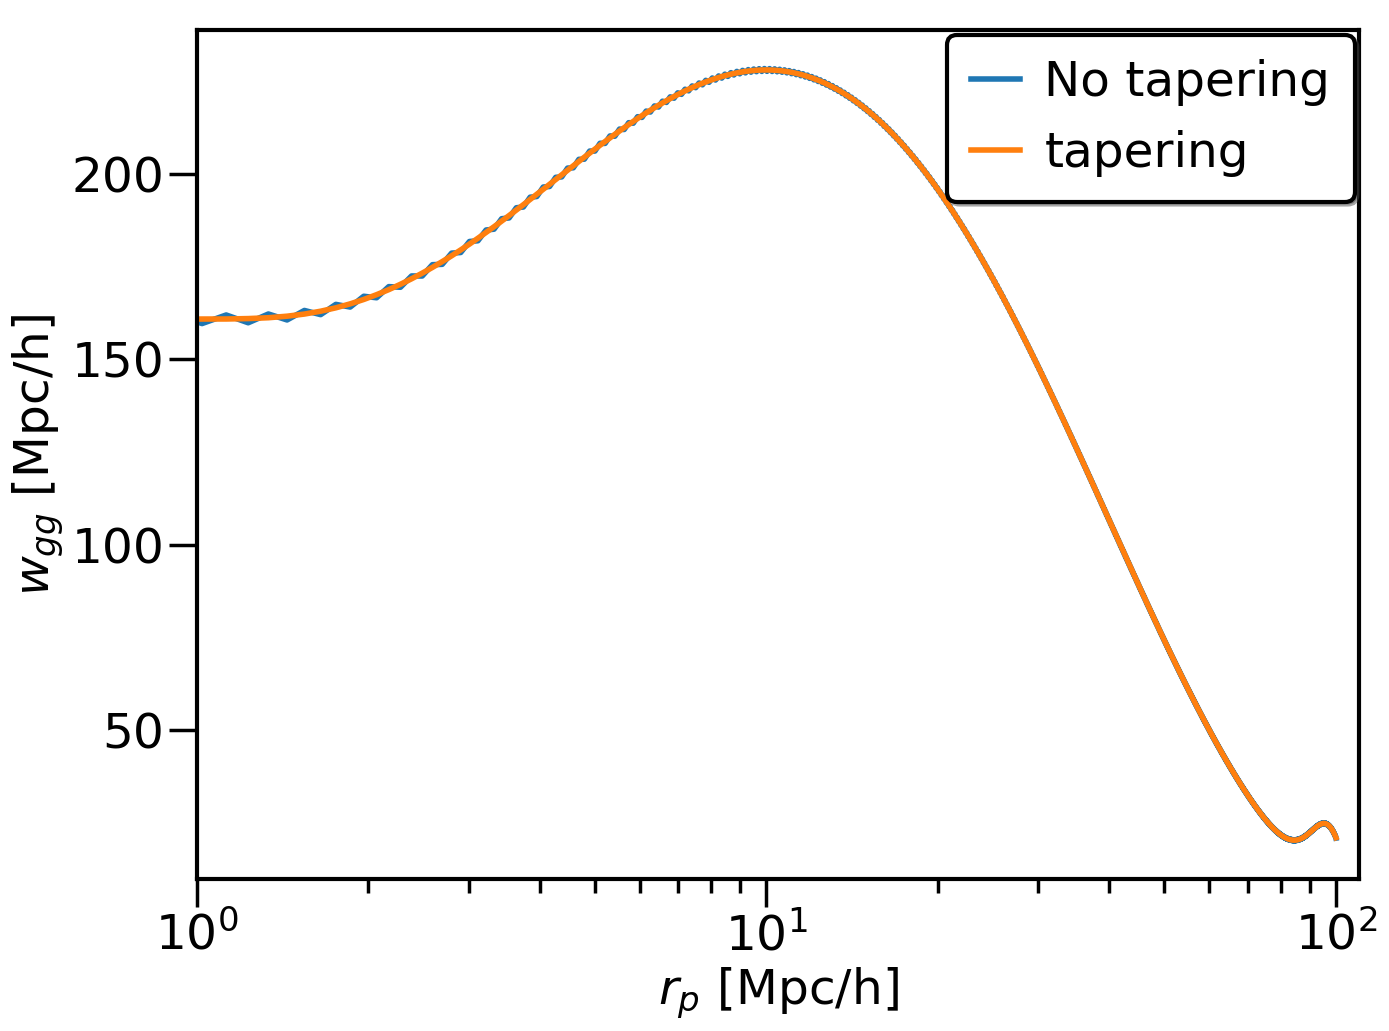

In [28]:
plot(r_gg,r_gg*wgg,label='No tapering')
plot(r_gg,r_gg*wgg_taper,label='tapering')
#plot(wgg_test['rp'],wgg_test['rp']*wgg_test['wgg']*wgg_test_fact)
xscale('log')
#yscale('log')
#ylim(1.e-2,1.e3)
xlim(1,110)
xlabel('$r_p$ [Mpc/h]')
ylabel('$w_{gg}$ [Mpc/h]')

legend()

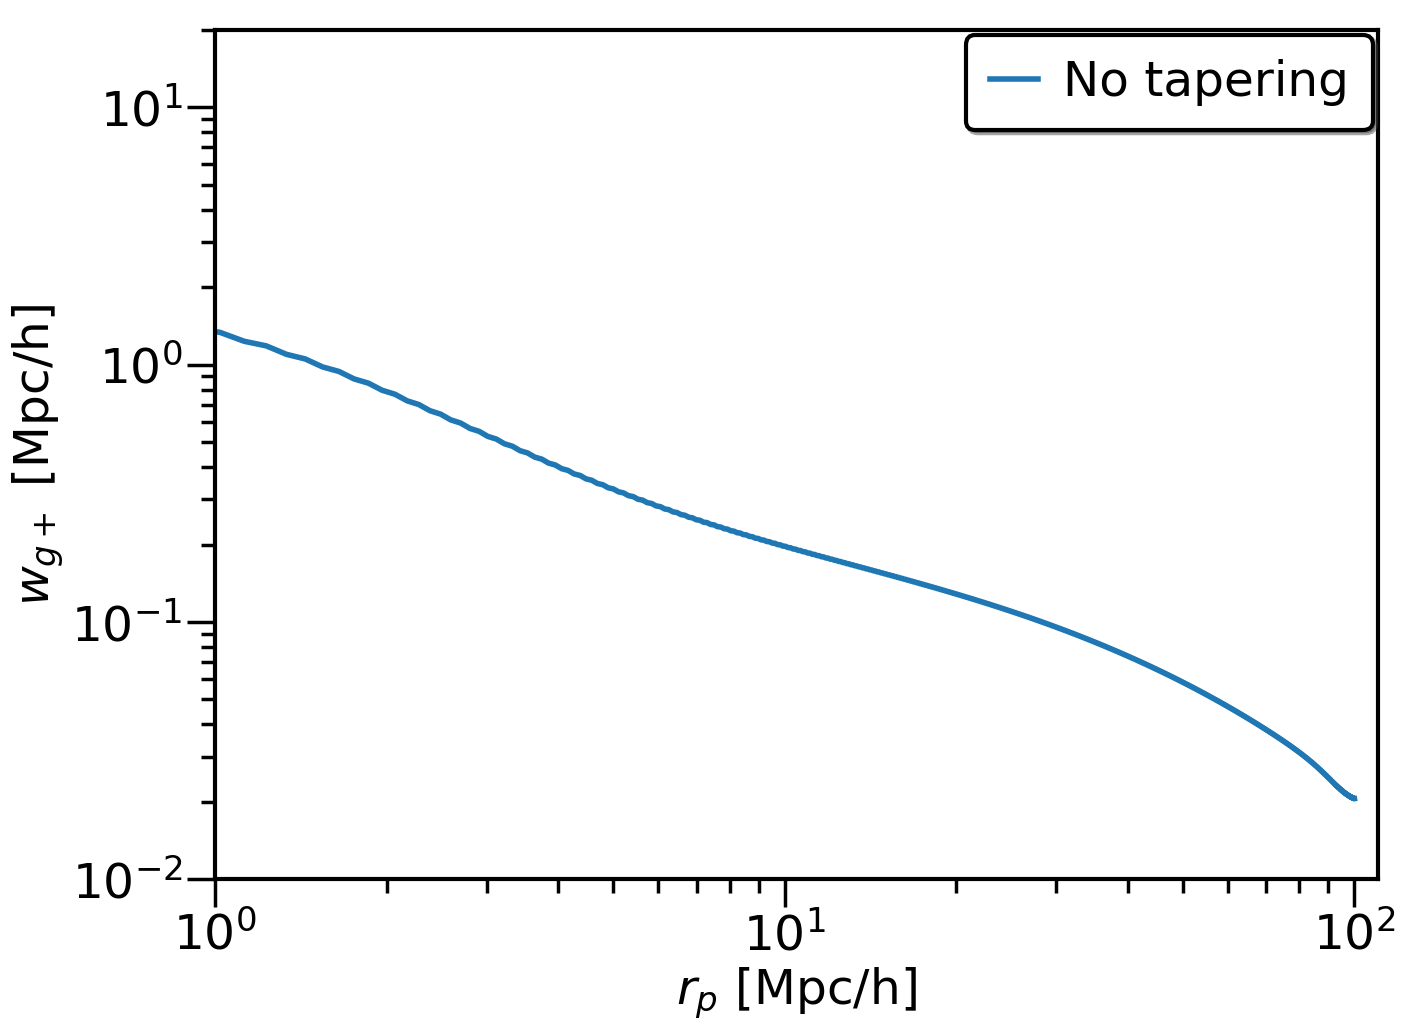

In [29]:
plot(r_gp,wgp,label='No tapering')
xscale('log')
yscale('log')
xlim(1,110)
xlabel('$r_p$ [Mpc/h]')
ylabel('$w_{g+}$ [Mpc/h]')
ylim(1.e-2,20)
legend()

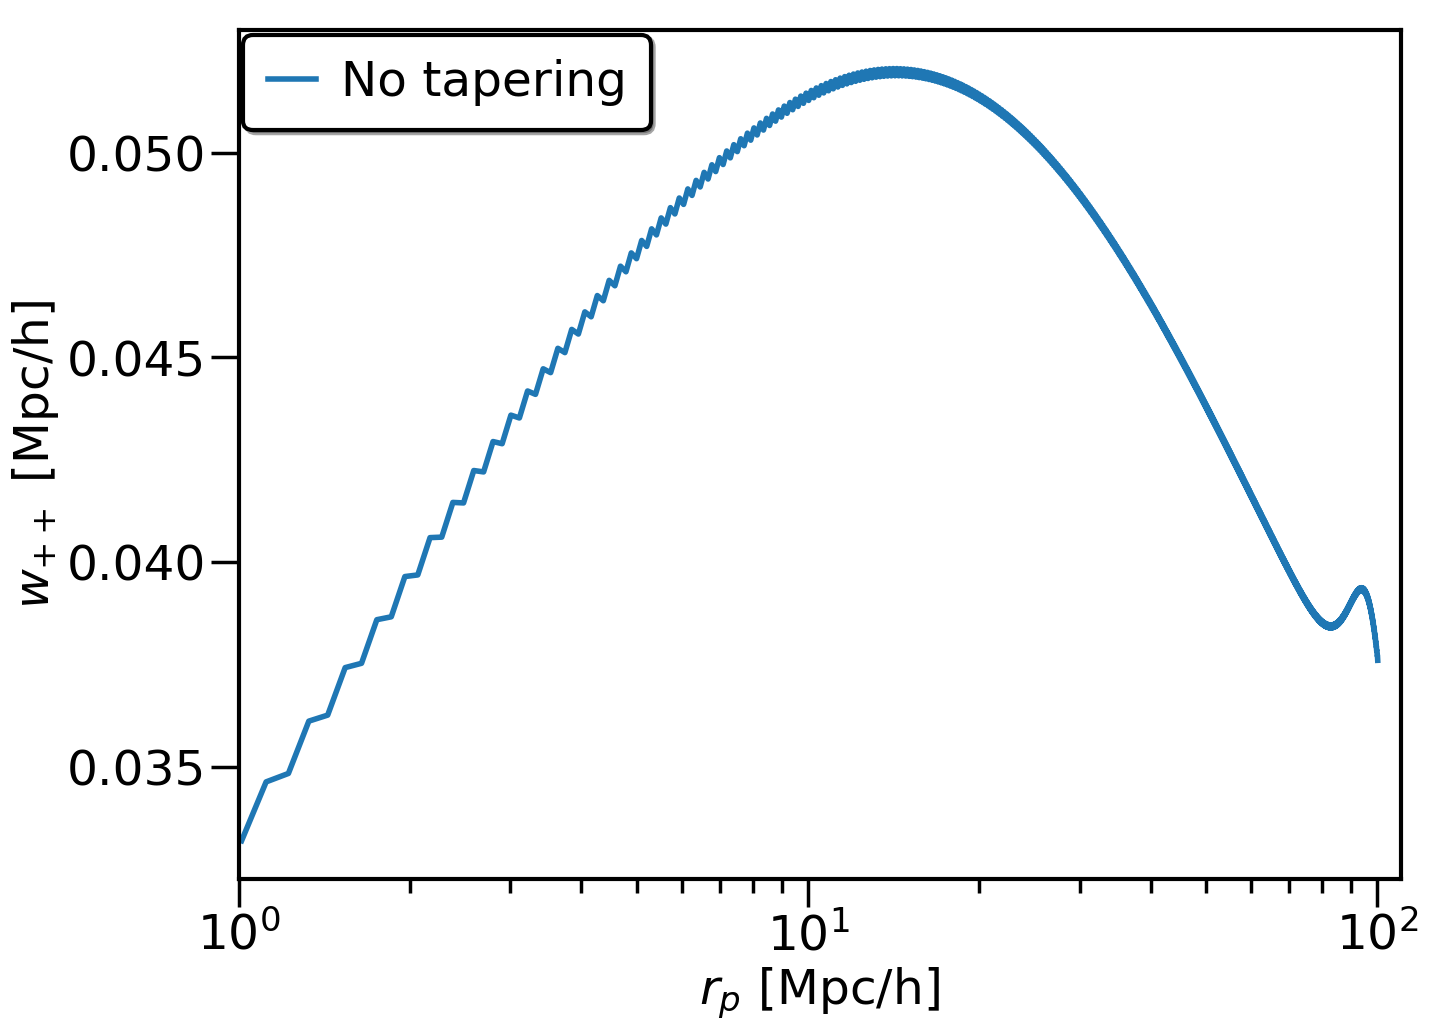

In [30]:
plot(r_pp,r_pp*wpp,label='No tapering')
xscale('log')
xlim(1,110)
xlabel('$r_p$ [Mpc/h]')
ylabel('$w_{++}$ [Mpc/h]')
# ylim(0,72)
legend()

Text(0.5, 0, '$r_p$ [Mpc/h]')

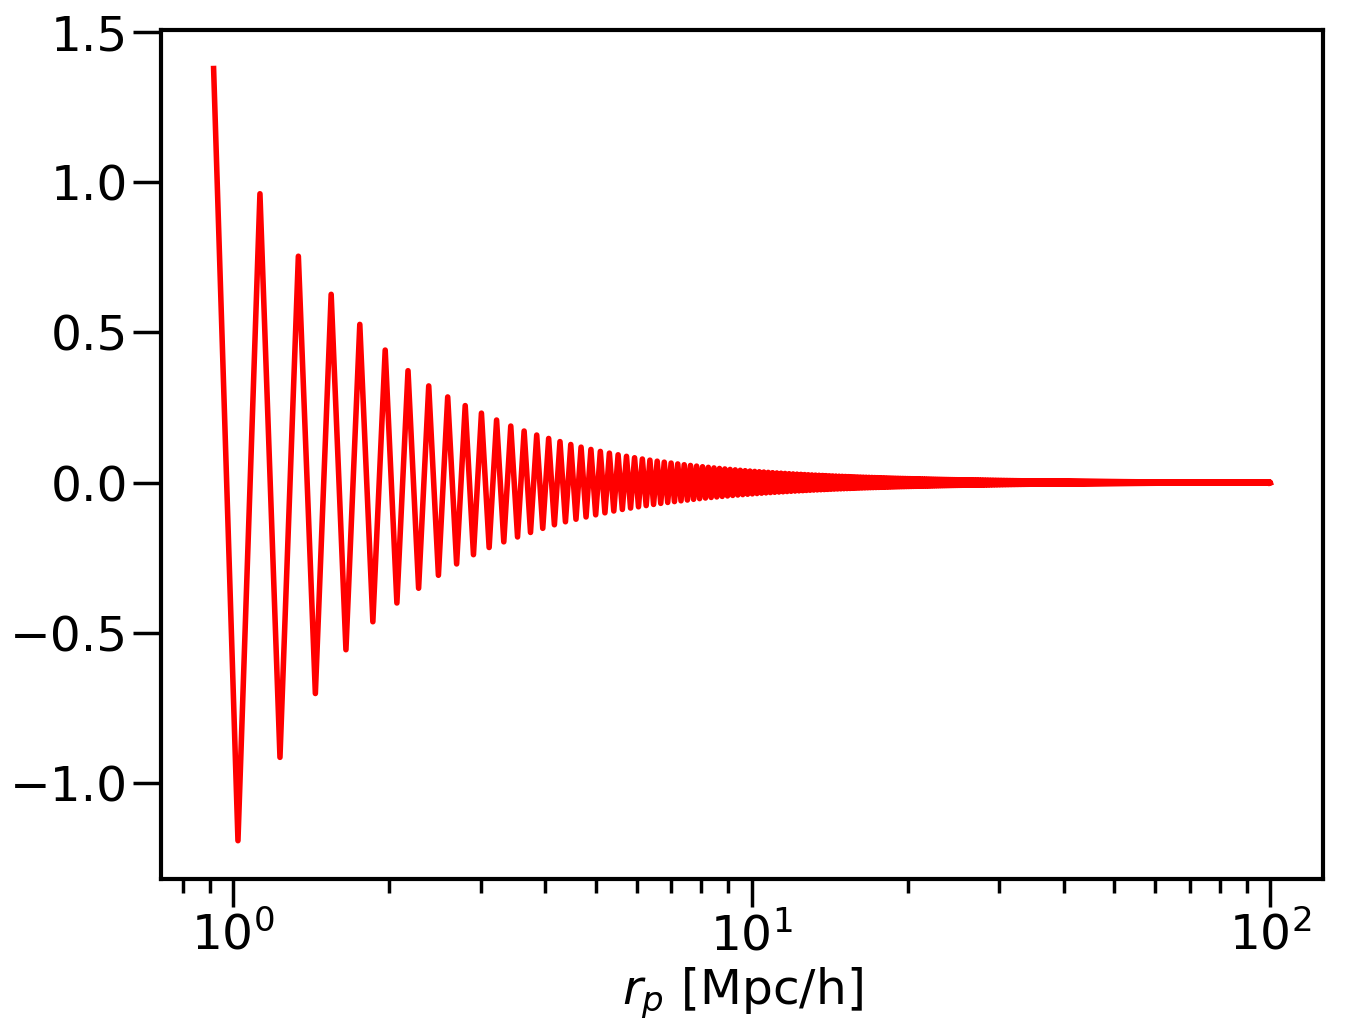

In [31]:
plot(r_gg,wgg-wgg_taper,'r')
xscale('log')
xlabel('$r_p$ [Mpc/h]')

# Covariance

In [32]:
n_g=3.e-4 #number density.. in units of Mpc ^ -3, same as pk
g_shot_noise=1./n_g
b_g=1.8
p_g=pk[0]*wgg_f

In [33]:
sigma_e=.36
sigma_gamma=sigma_e/1.7
n_s=n_g #shape galaxy number density 
shape_noise=sigma_gamma**2/n_s#*cosmo.H_z(z=0.27)/cosmo.c
p_gk=pk[0]*wgp_f
p_kk=pk[0]*wpp_f

In [34]:
#lensing contribution
l,cl=PS.kappa_cl(zs1=[z_mean],zs2=[z_mean],p_zs1=[1],p_zs2=[1],pk_func=PS.class_pk,zl_max=z_mean)
p_kappa=cl*cosmo.comoving_transverse_distance(z_mean)**2 #this is an approximation
k_kappa=l*cosmo.comoving_transverse_distance(z_mean)
p_kappa_int=interp1d(k_kappa,p_kappa,bounds_error=False, fill_value=0)
p_kappa=p_kappa_int(kh)

/home/deep/repos/Public-code/Hankel_transform/power_spectra.py:236: RuntimeWarning: divide by zero encountered in true_divide
  pk_int=interp1d(lz,pk[i]/DC_i**2,bounds_error=False,fill_value=0)
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [46]:
area=10000 #sq. degrees
area_comoving=area*(np.pi/180)**2*cosmo.comoving_distance(z=z_mean)**2
L_W=cosmo.comoving_distance(z=z_max)-cosmo.comoving_distance(z=z_min)
vol=area_comoving*L_W
vol=vol.value

In [36]:
p_g_cov=p_g+g_shot_noise
p_kk_cov=p_kk+p_kappa+shape_noise
p_gk_cov=p_gk

In [37]:
r,cov_ggkk=HT.projected_covariance(k_pk=kh,pk1=p_g_cov,pk2=p_kk_cov,j_nu=2)
r_re,cov_ggkk_re=HT.bin_cov(r=r,cov=cov_ggkk,r_bins=r_bins)
corr=HT.corr_matrix(cov=cov_ggkk_re)

/home/deep/repos/Public-code/Hankel_transform/hankel_transform.py:130: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


In [38]:
r,cov_gkgk=HT.projected_covariance(k_pk=kh,pk1=p_gk_cov,pk2=p_gk_cov,j_nu=2)#return_Jrr=True,Jrr=Jrr
r_re,cov_gkgk_re=HT.bin_cov(r=r,cov=cov_gkgk,r_bins=r_bins)
corr=HT.corr_matrix(cov=cov_gkgk_re)

In [47]:
cov_final=(cov_ggkk_re+cov_gkgk_re)/area
corr=HT.corr_matrix(cov=cov_final)
errors=HT.diagonal_err(cov=cov_final)

In [40]:
lowz_dat=np.genfromtxt('./test_Dat/lowz_full.dat',names=True)
lowz_cov=np.genfromtxt('./test_Dat//lowz_wgp_cov.dat')
lowz_corr=HT.corr_matrix(cov=lowz_cov)

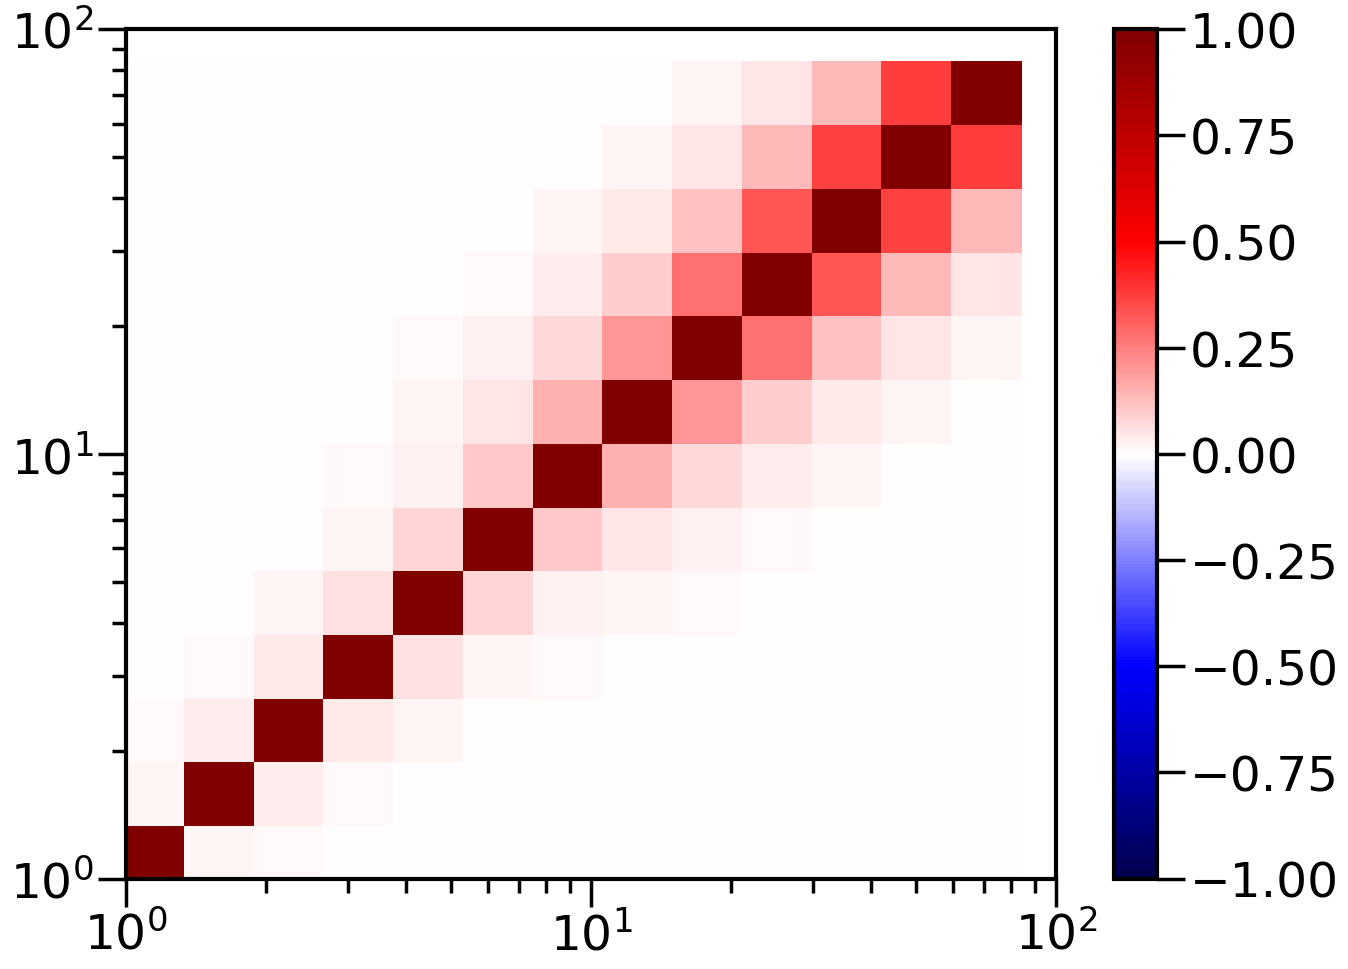

(1, 100)

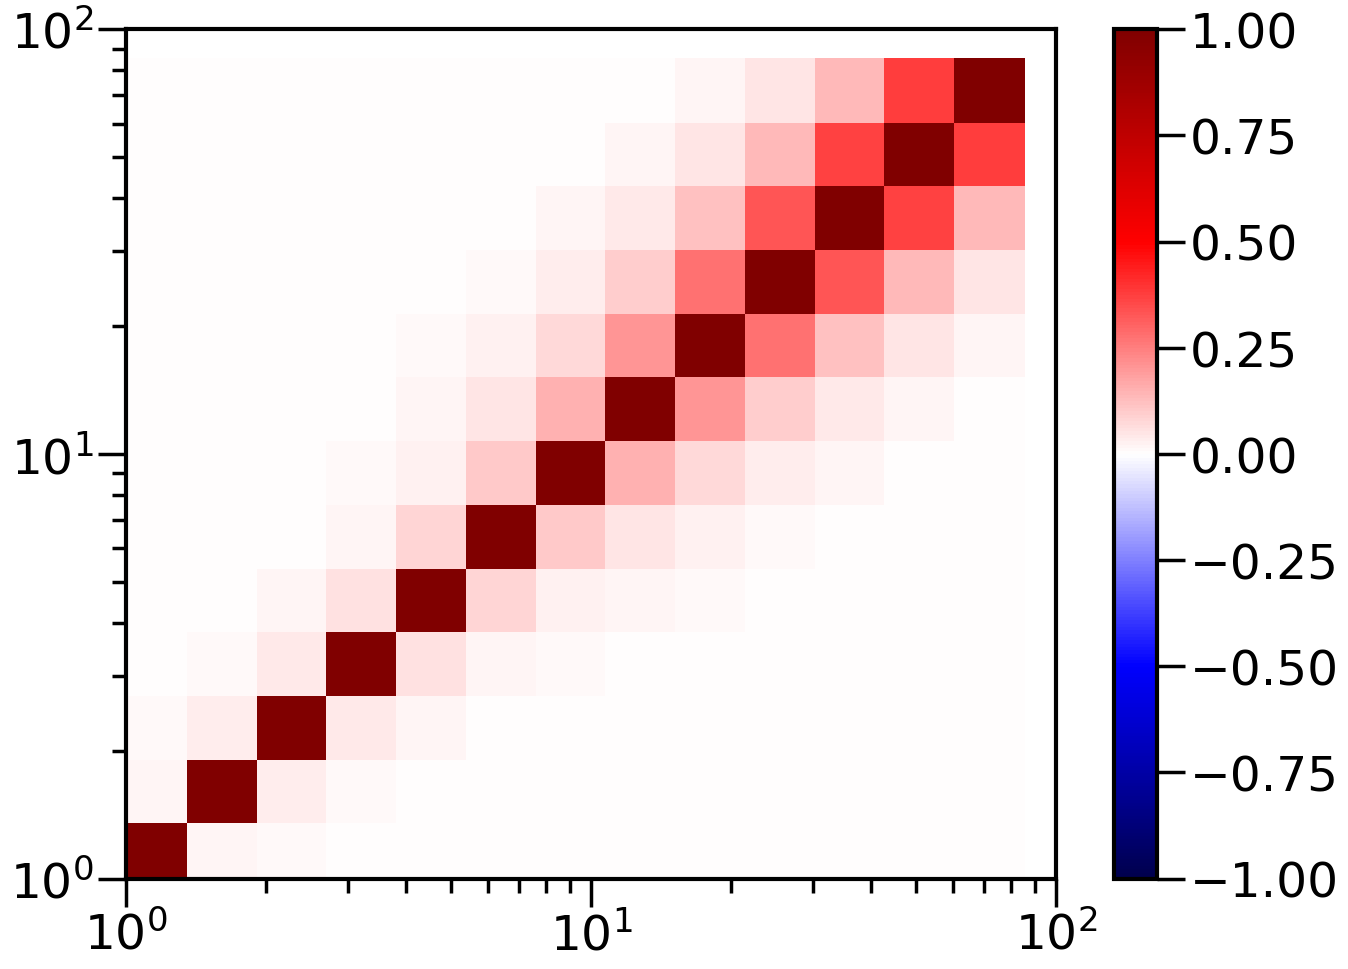

In [41]:
pcolor(r_re,r_re,corr,vmin=-1,vmax=1,cmap='seismic')
colorbar()
xscale('log')
yscale('log')
xlim(HT.rmin,HT.rmax)
ylim(HT.rmin,HT.rmax)
# colorbar()
show()
pcolor(lowz_dat['rp'],lowz_dat['rp'],corr,vmin=-1,vmax=1,cmap='seismic')
colorbar()
xscale('log')
yscale('log')
xlim(HT.rmin,HT.rmax)
ylim(HT.rmin,HT.rmax)
# colorbar()

(1, 110)

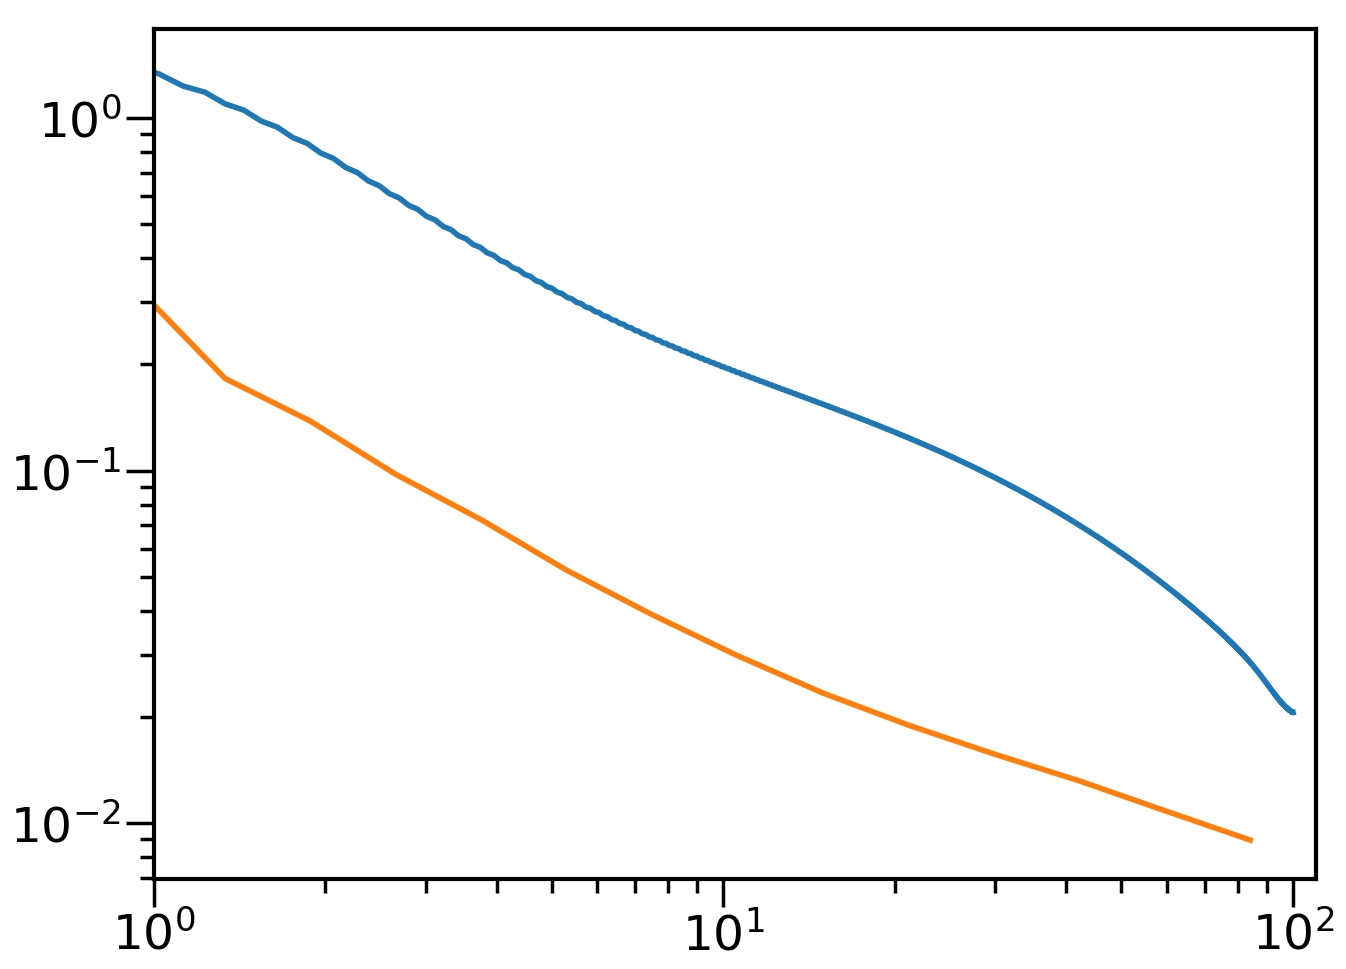

In [42]:
plot(r_gp,wgp)
plot(r_re,errors)
xscale('log')
yscale('log')
xlim(1,110)

(0.009, 2)

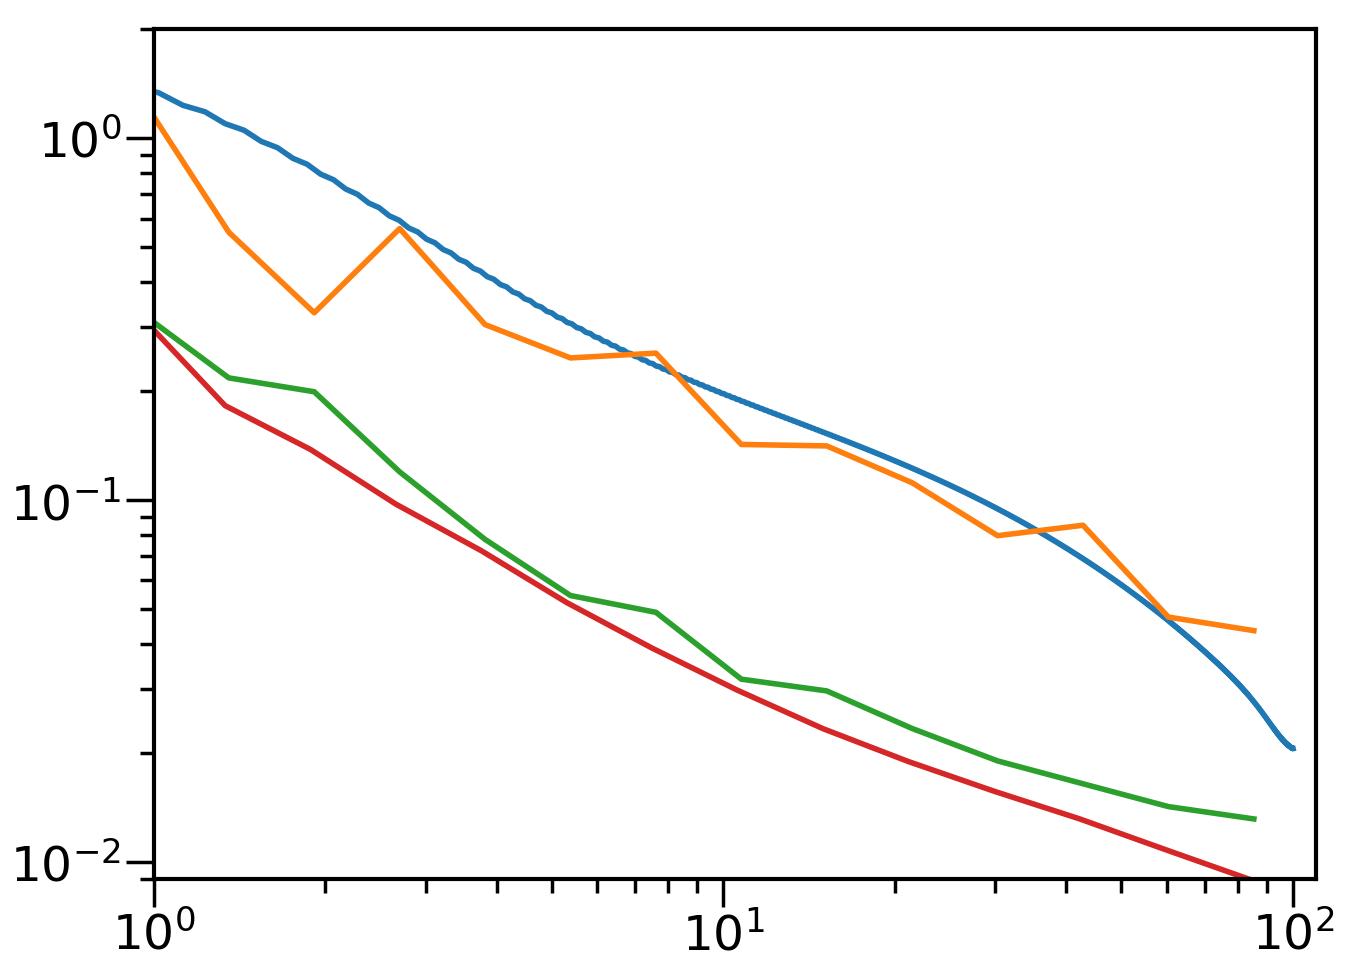

In [44]:
plot(r_gp,wgp)
plot(lowz_dat['rp'],lowz_dat['wgp'])
plot(lowz_dat['rp'],np.sqrt(np.diag(lowz_cov)))
plot(r_re,errors)
xscale('log')
yscale('log')
xlim(1,110)
ylim(9.e-3,2)